### Download Data

In [1]:
import pandas as pd
import numpy as np
# read data to pandas frame
url = 'https://raw.githubusercontent.com/Dr-Ning-An/Deep-Learning-with-Keras/main/NonlinearRegression/Data.csv'
data = pd.read_csv(url)
data.shape
# print(data.head(5))

(10000, 4)

In [2]:
inputs = data.iloc[:, 0:2]
inputs_norm = (inputs - inputs.mean()) / inputs.std()
n_inputs_norm = inputs_norm.shape[1]
print(inputs_norm.head(5))
outputs = data.iloc[:, 2:4]
outputs_norm = (outputs - outputs.mean()) / outputs.std()
n_outputs_norm = outputs_norm.shape[1]
print(outputs_norm.head(5))

   Coordinate x [m]  Distributed load q [kN/m]
0          1.522223                  -1.407221
1         -1.420730                   1.508714
2         -0.901141                  -0.937512
3          0.314005                  -1.665284
4         -0.920193                   1.273167
   Displacement u [m]  Curvature kappa [m-1]
0            0.722879              -0.207977
1           -0.955251              -0.227143
2           -1.005059              -1.176568
3           -0.465783              -1.019123
4           -0.646611               0.090442


In [3]:
from sklearn.model_selection import train_test_split
# Randomly split the data into a training and test sets by holding 30% of the data for testing.
inputs_norm_train, inputs_norm_test, outputs_norm_train, outputs_norm_test = \
    train_test_split(inputs_norm, outputs_norm, test_size = 0.3, random_state=0)

In [4]:
import keras
from keras.layers import Dense
import tensorflow as tf

# define regression model using Functional API
def build_model():
    # create model
    inputs = tf.keras.Input(shape=(n_inputs_norm,), dtype=tf.float64)
    dense1 = Dense(128, activation='tanh')(inputs)
    dense2 = Dense(64, activation='tanh')(dense1)
    dense3 = Dense(32, activation='tanh')(dense2)
    dense4 = Dense(16, activation='tanh')(dense3)
    outputs = Dense(n_outputs_norm)(dense4)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# build the model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 11,282
Trainable params: 11,282
Non-trainable p

In [6]:
optimizer = tf.keras.optimizers.Adam()

In [7]:
BATCH_SIZE = 60
EPOCHS = 200

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((inputs_norm_train, outputs_norm_train))
dataset = dataset.batch(BATCH_SIZE)

In [9]:
def PGNN(x_norm, q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        outputs_norm_pred = tf.cast(model(tf.stack([x_norm,q_norm], axis=1)), tf.float64)
        u_norm = outputs_norm_pred[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm) 
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm) 

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    kappa_norm = outputs_norm_pred[:,1]
    kappa = kappa_norm * outputs.std()[1] + outputs.mean()[1]
    
    residual = d2u_dx2 - kappa

    return residual

In [10]:
def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        outputs_pred = tf.cast(model(inputs), tf.float64)
        residual = PGNN(inputs[:,0],inputs[:,1])
        loss1 = tf.losses.MeanSquaredError()(outputs, outputs_pred) 
        loss2 = tf.reduce_mean(tf.square(residual))
        loss = loss1 + loss2

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, (inputs_norm_train_batch, outputs_norm_train_batch) in enumerate(dataset):
        loss_i = train_step(inputs_norm_train_batch, outputs_norm_train_batch)
        ep_loss.append(loss_i)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")

Epoch 0 Loss: 29.881800524222843
Epoch 1 Loss: 3.1939223198866
Epoch 2 Loss: 1.9312020360512054
Epoch 3 Loss: 1.0638581769410804
Epoch 4 Loss: 0.9776514095227874
Epoch 5 Loss: 0.5789449806697542
Epoch 6 Loss: 0.4353435694443928
Epoch 7 Loss: 0.36981790804853487
Epoch 8 Loss: 0.28063599276631307
Epoch 9 Loss: 0.24151760839229075
Epoch 10 Loss: 0.22823461731157596
Epoch 11 Loss: 0.23494239932507593
Epoch 12 Loss: 0.22354700726157073
Epoch 13 Loss: 0.1223847869454357
Epoch 14 Loss: 0.16921690577614262
Epoch 15 Loss: 0.1254658735912779
Epoch 16 Loss: 0.11282611469868405
Epoch 17 Loss: 0.09168051895368859
Epoch 18 Loss: 0.08531247315494254
Epoch 19 Loss: 0.08170429495273698
Epoch 20 Loss: 0.046817623662128605
Epoch 21 Loss: 0.10567429224280804
Epoch 22 Loss: 0.0421995314709255
Epoch 23 Loss: 0.057077238952921064
Epoch 24 Loss: 0.06518584504837074
Epoch 25 Loss: 0.046048590340707275
Epoch 26 Loss: 0.03166687783879507
Epoch 27 Loss: 0.04288903395908991
Epoch 28 Loss: 0.15718396888415218
Epoch

In [11]:
test_data = outputs_norm_test * outputs.std() + outputs.mean()
print(test_data)
test_data_disp = test_data.to_numpy()[:,0]
test_data_kappa = test_data.to_numpy()[:,1]

      Displacement u [m]  Curvature kappa [m-1]
9394            2.374574               9.334805
898             2.212246               9.747763
2398            2.851196              11.662809
5906           13.029009              20.449480
2343            6.448158              14.567710
...                  ...                    ...
4004           11.032060              19.409858
7375            3.926963               9.757329
9307           13.574592              20.677069
8394           12.160769              18.607801
5233            4.635886              13.574874

[3000 rows x 2 columns]


In [12]:
pred_data_norm = model.predict(inputs_norm_test)
pred_data_norm_df = pd.DataFrame(pred_data_norm, columns = ['Displacement u [m]','Curvature kappa [m-1]'])
pred_data_df = pred_data_norm_df * outputs.std() + outputs.mean()
print(pred_data_df)
pred_data_disp = pred_data_df.to_numpy()[:,0]
pred_data_kappa = pred_data_df.to_numpy()[:,1]

94/94 [==============================] - 0s 1ms/step
      Displacement u [m]  Curvature kappa [m-1]
0               2.364724               9.180284
1               2.243100               9.635612
2               2.900850              11.593477
3              12.988190              20.498561
4               6.443552              14.511677
...                  ...                    ...
2995           11.002512              19.490296
2996            3.894128               9.759139
2997           13.531002              20.720142
2998           12.114376              18.744579
2999            4.659366              13.488950

[3000 rows x 2 columns]


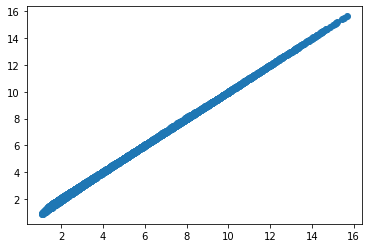

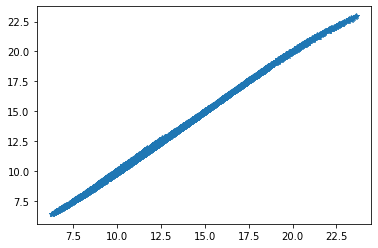

In [13]:
# Evaluate the mdoel on the test data and compare the error between predictions and true data
import matplotlib.pyplot as plt
plt.plot(test_data_disp, pred_data_disp, 'o')
plt.show()
plt.plot(test_data_kappa, pred_data_kappa, '*')
plt.show()

In [14]:
import tensorflow as tf
def F_model(model,x_norm,q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        u_norm = model(tf.stack([x_norm,q_norm], axis=1))[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm)  
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm)  

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    u = u_norm * outputs.std()[0] + outputs.mean()[0]

    return u, d2u_dx2

tf.Tensor(
[ 9.21041258  9.67259332 11.61780251 ... 20.75977185 18.79142715
 13.5135359 ], shape=(3000,), dtype=float64)


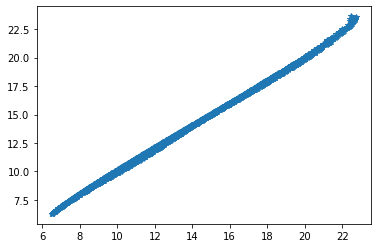

In [15]:
x_norm = inputs_norm_test.to_numpy()[:,0]
q_norm = inputs_norm_test.to_numpy()[:,1]
[u, d2u_dx2] = F_model(model, x_norm, q_norm)
print(d2u_dx2)
plt.plot(d2u_dx2, test_data_kappa, '*')
plt.show()